In [1]:
import random

import gymnasium as gym
import numpy as np
import torch
import torch.optim as optim

from stable_baselines3.common.buffers import ReplayBuffer

import sys
sys.path.append('../..')

from src.rlmcmc.agent import Actor, QNetwork
from src.rlmcmc.env import RLMHEnvV31
from src.rlmcmc.utils import Args, MCMCAnimation, Toolbox
from src.rlmcmc.learning import LearningDDPG

In [2]:
log_p = Toolbox.make_log_target_pdf(
    "test-banana_rotation-test-banana_rotation",
    "../../posteriordb/posterior_database"
)

In [3]:
# env setup
args = Args()
args.seed = 1234
args.log_target_pdf = log_p
args.total_timesteps = 100_000
args.batch_size = 32
args.learning_starts = args.batch_size
# args.learning_starts = 5_000
args.gamma = 0.7
# args.buffer_size = args.total_timesteps
args.learning_rate = 1e-4
args.policy_frequency = 2

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=args.log_target_pdf,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)
predicted_envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=args.log_target_pdf,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)
assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

actor = Actor(envs).to(device)
actor = actor.double()
actor = torch.compile(actor)
qf1 = QNetwork(envs).to(device)
qf1 = qf1.double()
qf1 = torch.compile(qf1)
qf1_target = QNetwork(envs).to(device)
qf1_target = qf1_target.double()
qf1_target = torch.compile(qf1_target)
target_actor = Actor(envs).to(device)
target_actor = target_actor.double()
target_actor = torch.compile(target_actor)
target_actor.load_state_dict(actor.state_dict())
qf1_target.load_state_dict(qf1.state_dict())
q_optimizer = optim.Adam(list(qf1.parameters()), lr=args.learning_rate)
actor_optimizer = optim.Adam(list(actor.parameters()), lr=args.learning_rate)

envs.single_observation_space.dtype = np.float64
rb = ReplayBuffer(
    args.buffer_size,
    envs.single_observation_space,
    envs.single_action_space,
    device,
    handle_timeout_termination=False
)

In [4]:
learning = LearningDDPG(
    env=envs,
    actor=actor,
    target_actor=target_actor,
    critic=qf1,
    target_critic=qf1_target,
    actor_optimizer=actor_optimizer,
    critic_optimizer=q_optimizer,
    replay_buffer=rb,
    total_timesteps=args.total_timesteps,
    learning_starts=args.learning_starts,
    batch_size=args.batch_size,
    gamma=args.gamma,
    policy_frequency=args.policy_frequency,
    tau=args.tau,
    seed=args.seed,
    device=device
)

  0%|          | 0/100000 [00:00<?, ?it/s]

[2024-01-21 02:40:03,571] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_3
[2024-01-21 02:40:03,571] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_2
[2024-01-21 02:40:03,572] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_1
[2024-01-21 02:40:03,572] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split
[2024-01-21 02:40:07,719] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_3
[2024-01-21 02:40:07,719] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_2
[2024-01-21 02:40:07,720] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_1
[2024-01-21 02:40:07,720] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split
[2024-01-21 02:40:08,489] [1/0] torch._inductor.fx_passes.sp

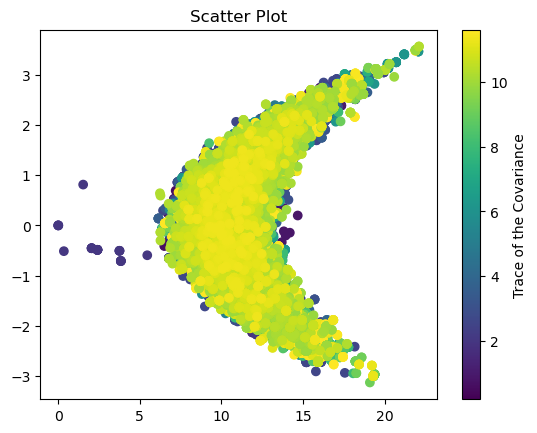

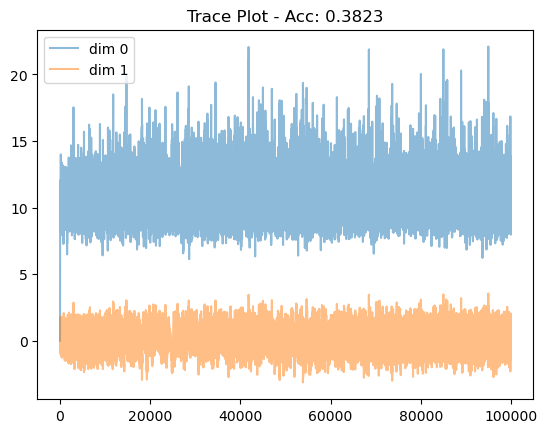

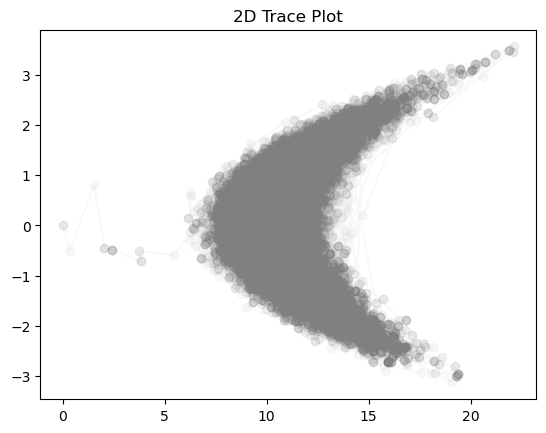

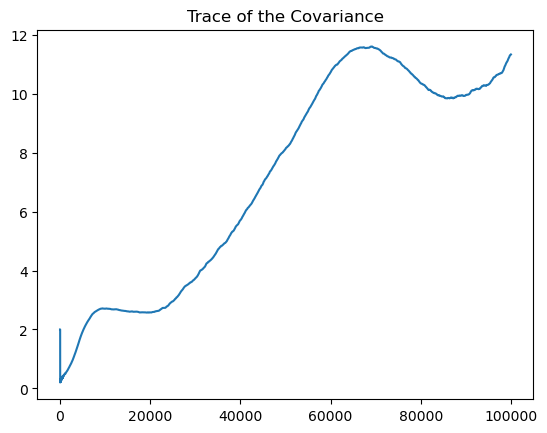

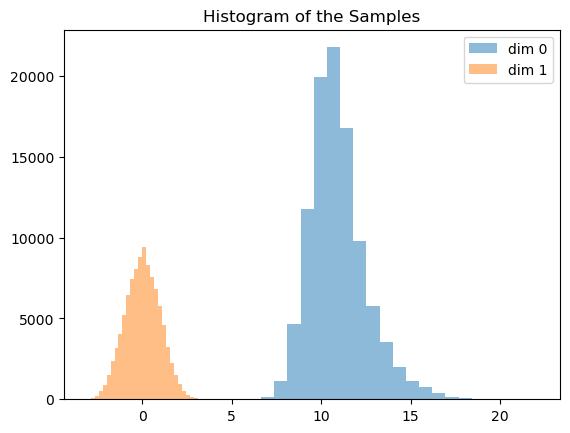

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

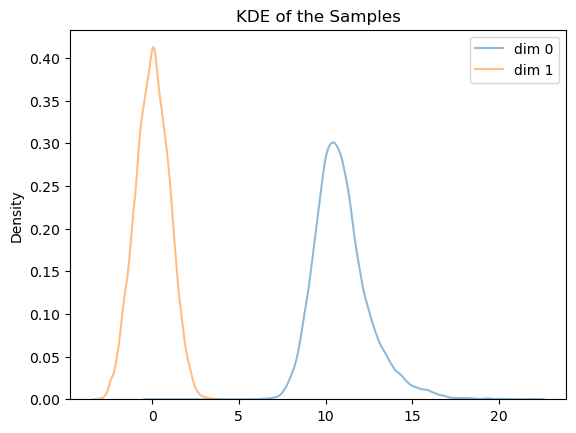

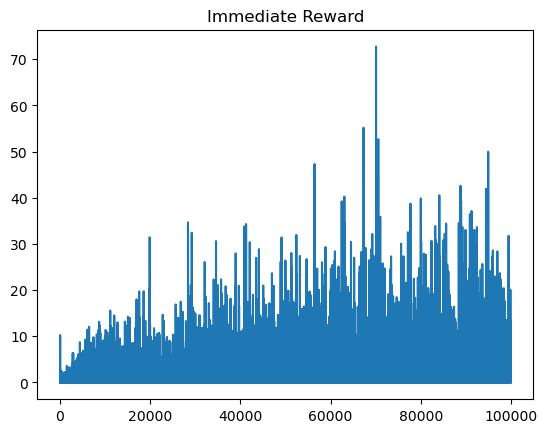

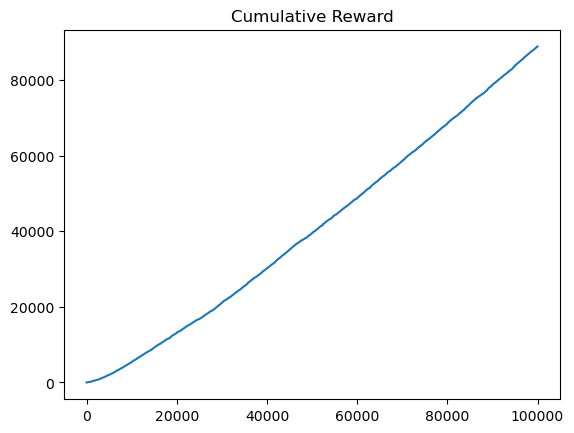

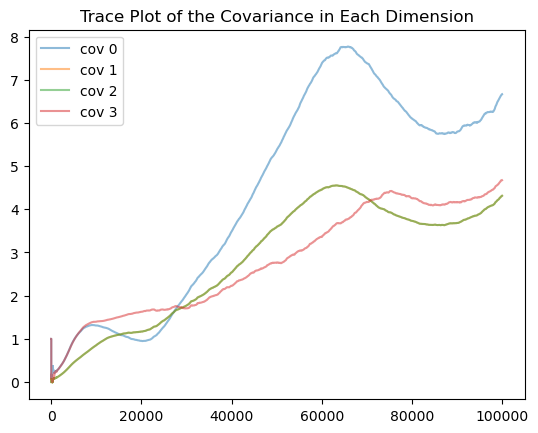

In [5]:
learning_func = learning.train()
learning_func.plot()

  0%|          | 0/5000 [00:00<?, ?it/s]

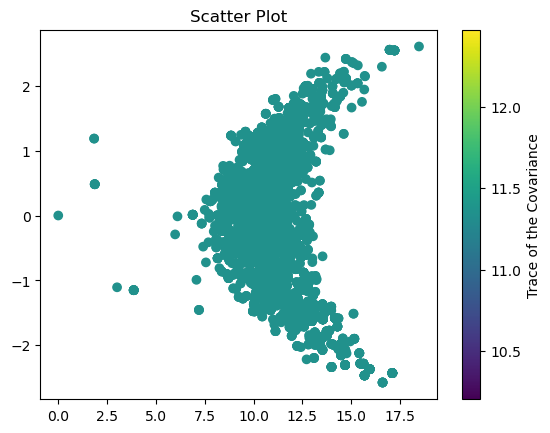

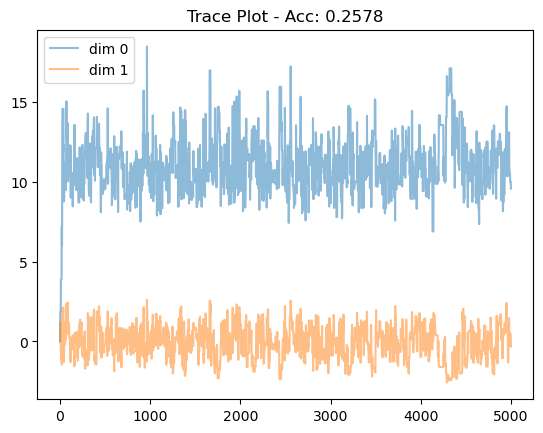

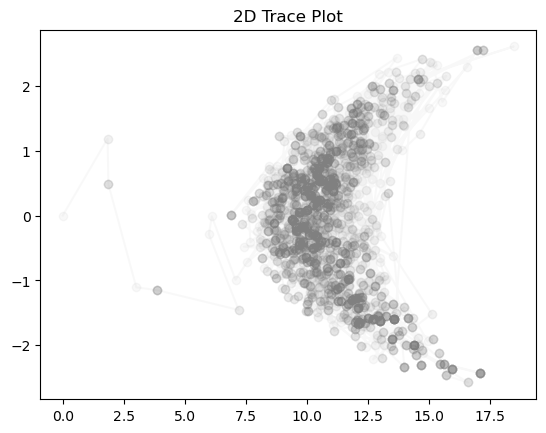

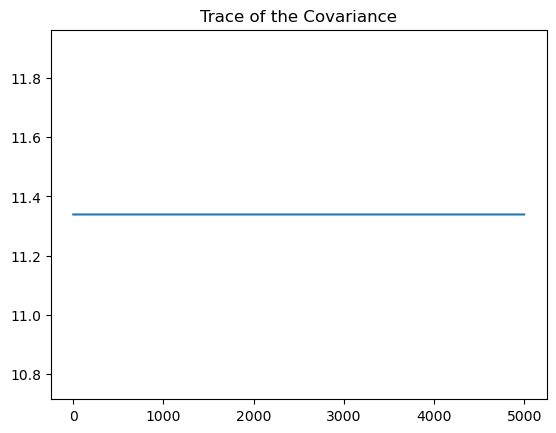

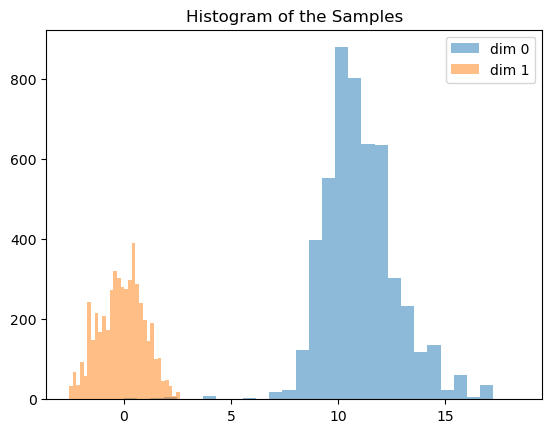

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

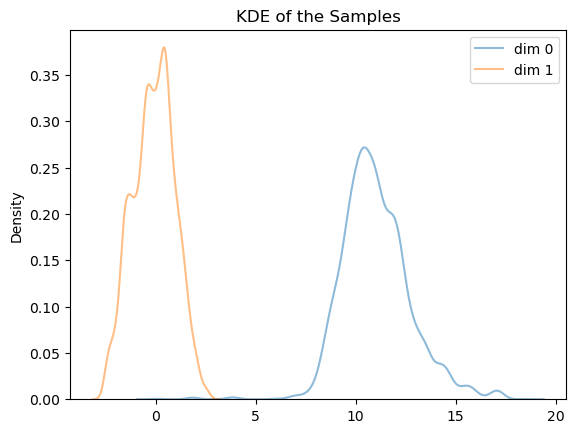

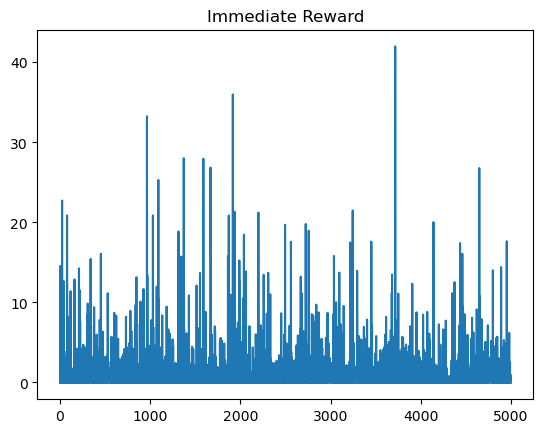

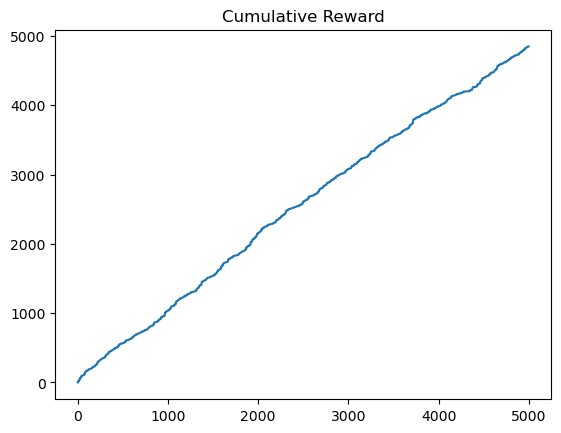

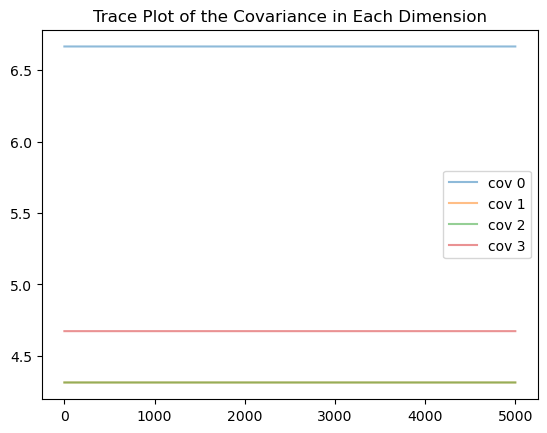

In [6]:
predict_func = learning.predict(predicted_envs, 5_000)
predict_func.plot()

In [7]:
predict_func.dataframe().to_csv("save/data/predict.csv", index=False)

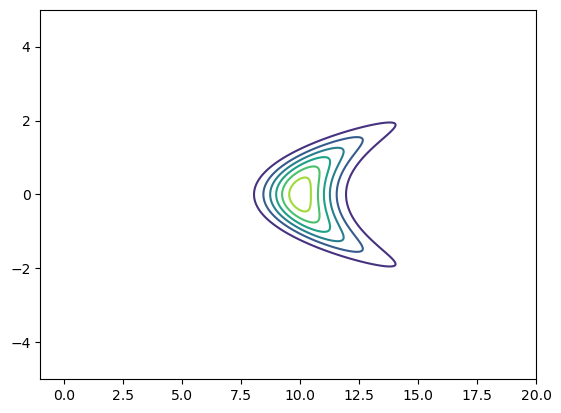

In [8]:
mcmc_animation = MCMCAnimation(
    log_target_pdf=log_p,
    dataframe=predict_func.dataframe(),
    xlim=(-1, 20),
    ylim=(-5, 5)
    )

In [9]:
anim_file_path = "./save/data/banana_rotation.mp4"
mcmc_animation.make().save(anim_file_path, writer='ffmpeg')

In [11]:
learning.save("save/model")